**report** for build and test env = random agent
- goal: ktra env mini tetris 8x12, xác nhận rằng khi không có thuật toán, agent chọn hành động ngẫu nhiên, hành vi thu được bất ổn và dễ die. Thiết lâp base line = 0 before train AI, để so sánh sau này.
- Cấu hình: env Mini tetris 8x12;  reward +1 cho mỗi dòng xoá, -0.01 cho mỗi bước;  Action space bao gồm: 0- no op, 1 move left, 2 right, 3 rotate, 4 soft drop; Agent là random agent (action = random.choice[0,1,2,3,4]. -> no policy, no hẻuistic, no RL
- Quy trình: khởi tạo env, tại mỗi bước, agent rand action 0-4, thực hiện step, hiển thị trạng thái trò chơi = renđẻ, lăph lại cho tới khi game over
- KQ: agent di chuyển ko mục đích, không chính sách -> ngu. Board lộn xộn, sinh ra holes, k sống lâu. Sau khoảng 20-40 step game over.
- Explain: No policy, rw -0.01 làm agent thiệt khi kéo dài, tỉ lệ sống thấp.
- Conclúion: Base line env cho thấy rand agent không sống lâu khi không có algỏithms.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

class TetrisEnvNoPolicy:
    def __init__(self, H=12, W=8, gravity_speed=0.1):
        self.H = H
        self.W = W
        self.gravity_speed = gravity_speed

        self.COLORS = {
            0: (0,0,0),
            1: (0,1,1),
            2: (1,1,0),
            3: (0.6,0,0.8),
            4: (1,0.5,0),
            5: (0,0,1),
            6: (0,1,0),
            7: (1,0,0),
        }

        self.reset()

    #Tetromino
    def get_tetrominoes(self):
        return {
            1: [np.array([[1,1,1,1]]),
                np.array([[1],[1],[1],[1]]),
                np.array([[1,1,1,1]]),
                np.array([[1],[1],[1],[1]])],

            2: [np.array([[2,2],
                          [2,2]])] * 4,

            3: [np.array([[0,3,0],[3,3,3]]),
                np.array([[3,0],[3,3],[3,0]]),
                np.array([[3,3,3],[0,3,0]]),
                np.array([[0,3],[3,3],[0,3]])],

            4: [np.array([[4,0],[4,0],[4,4]]),
                np.array([[4,4,4],[4,0,0]]),
                np.array([[4,4],[0,4],[0,4]]),
                np.array([[0,0,4],[4,4,4]])],

            5: [np.array([[0,5],[0,5],[5,5]]),
                np.array([[5,0,0],[5,5,5]]),
                np.array([[5,5],[5,0],[5,0]]),
                np.array([[5,5,5],[0,0,5]])],

            6: [np.array([[0,6,6],[6,6,0]]),
                np.array([[6,0],[6,6],[0,6]]),
                np.array([[0,6,6],[6,6,0]]),
                np.array([[6,0],[6,6],[0,6]])],

            7: [np.array([[7,7,0],[0,7,7]]),
                np.array([[0,7],[7,7],[7,0]]),
                np.array([[7,7,0],[0,7,7]]),
                np.array([[0,7],[7,7],[7,0]])]
        }

    #RESET
    def reset(self):
        self.board = np.zeros((self.H, self.W), dtype=int)
        self.tetrominoes = self.get_tetrominoes()

        self.current_id = random.randint(1,7)
        self.next_id = random.randint(1,7)

        self.rotation = 0
        self.piece = self.tetrominoes[self.current_id][self.rotation]

        self.px = self.W//2 - 2
        self.py = 0

        self.score = 0
        self.done = False

        self._line_reward = 0

        return self.get_state()

    #Collision
    def collision(self, px, py, piece):
        for r in range(len(piece)):
            for c in range(len(piece[0])):
                if piece[r][c] != 0:
                    br = py + r
                    bc = px + c
                    if br < 0 or br >= self.H or bc < 0 or bc >= self.W:
                        return True
                    if self.board[br][bc] != 0:
                        return True
        return False

    #Lock + Clear + Spawn
    def lock_piece(self):
        p = self.piece
        for r in range(len(p)):
            for c in range(len(p[0])):
                if p[r][c] != 0:
                    self.board[self.py + r][self.px + c] = p[r][c]

        self.clear_lines()
        self.spawn_new_piece()

    def spawn_new_piece(self):
        self.current_id = self.next_id
        self.next_id = random.randint(1,7)

        self.rotation = 0
        self.piece = self.tetrominoes[self.current_id][0]
        self.px = self.W//2 - 2
        self.py = 0

        if self.collision(self.px, self.py, self.piece):
            self.done = True

    def clear_lines(self):
        full = [i for i in range(self.H) if np.all(self.board[i] != 0)]

        if len(full) > 0:
            self.board = np.delete(self.board, full, axis=0)
            self.board = np.vstack((np.zeros((len(full), self.W), int), self.board))

            self.score += len(full)
            self._line_reward = len(full)
        else:
            self._line_reward = 0

    #Rotate
    def rotate_piece(self):
        new_rot = (self.rotation + 1) % 4
        new_piece = self.tetrominoes[self.current_id][new_rot]

        if not self.collision(self.px, self.py, new_piece):
            self.rotation = new_rot
            self.piece = new_piece

    #STEP
    # 0 no-op, 1 left, 2 right, 3 rotate, 4 soft drop
    def step(self, action):

        if self.done:
            return self.get_state(), 0, True

        # LEFT
        if action == 1 and not self.collision(self.px - 1, self.py, self.piece):
            self.px -= 1

        # RIGHT
        if action == 2 and not self.collision(self.px + 1, self.py, self.piece):
            self.px += 1

        # ROTATE
        if action == 3:
            self.rotate_piece()

        # SOFT DROP
        if action == 4 and not self.collision(self.px, self.py + 1, self.piece):
            self.py += 1

        # GRAVITY
        if self.collision(self.px, self.py + 1, self.piece):
            self.lock_piece()
        else:
            self.py += 1

        # NEW REWARD SYSTEM
        rw = -0.01 + self._line_reward

        return self.get_state(), rw, self.done

    #STATE
    def get_state(self):
        temp = self.board.copy()

        if self.done:
            return temp

        p = self.piece
        for r in range(len(p)):
            for c in range(len(p[0])):
                if p[r][c] != 0:
                    br = self.py + r
                    bc = self.px + c
                    if 0 <= br < self.H and 0 <= bc < self.W:
                        temp[br][bc] = p[r][c]
        return temp

    def get_next_piece_matrix(self):
        return self.tetrominoes[self.next_id][0]

    #RENDER
    def render(self, pause=0.1, info_text = None):
        clear_output(wait=True)

        state = self.get_state()
        rgb = np.zeros((self.H, self.W, 3))

        for r in range(self.H):
            for c in range(self.W):
                rgb[r,c] = self.COLORS[state[r,c]]

        ghost_y = None
        if not self.done:
            gy=self.py
            while not self.collision(self.px, gy+1, self.piece):
                gy += 1
            ghost_y = gy


        fig, (ax_board, ax_next) = plt.subplots(
            1, 2, figsize=(6,8),
            gridspec_kw={'width_ratios': [3,1]}
        )

        #Board
        ax_board.imshow(rgb)
        ax_board.set_title(f"Mini Tetris | Score: {self.score}")
        ax_board.set_xticks([]); ax_board.set_yticks([])

        for y in range(self.H):
            for x in range(self.W):
                ax_board.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='0.3', linewidth=0.5))
        for y in range(self.H):
            for x in range(self.W):
                if state[y,x] != 0:
                    ax_board.add_patch(plt.Rectangle((x-0.5, y-0.5),1,1,fill=False,edgecolor='white',linewidth=1.5))

        if (ghost_y is not None) and (ghost_y != self.py):
            p = self.piece
            for r in range(len(p)):
                for c in range(len(p[0])):
                  if p[r,c] != 0:
                    gy= ghost_y + r
                    gx = self.px + c
                    if 0 <= gy < self.H and 0 <= gx < self.W:
                        ax_board.add_patch(plt.Rectangle((gx-0.5, gy-0.5),1,1,fill=True,facecolor='white', alpha=0.18, edgecolor='white',linewidth=0.7,linestyle='dashed'))
        if self.done:
            # GAME OVER
            ax_board.text(
                self.W/2 - 0.5,
                self.H/2 - 1.0,
                "GAME OVER",
                ha='center', va='center',
                fontsize=20, fontweight='bold',
                color='red',
                bbox=dict(facecolor='white', alpha=0.85, boxstyle="round")
            )

            if info_text is not None:
                ax_board.text(
                    self.W/2 - 0.5,
                    self.H/2 + 1.0,
                    info_text,
                    ha='center', va='center',
                    fontsize=12,
                    color='white',
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle="round")
                )

        #Next piece
        next_p = self.get_next_piece_matrix()
        h, w = next_p.shape
        size = 4
        preview = np.zeros((size, size, 3))
        offset_r = (size - h) // 2
        offset_c = (size - w) // 2

        for r in range(h):
            for c in range(w):
                val = next_p[r, c]
                if val != 0:
                    preview[offset_r + r, offset_c + c] = self.COLORS[val]

        ax_next.imshow(preview)
        ax_next.set_title("Next")
        ax_next.set_xticks([]); ax_next.set_yticks([])

        for y in range(size):
            for x in range(size):
                ax_next.add_patch(
                    plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=False,edgecolor='white',linewidth=0.8))

        plt.tight_layout()
        plt.show()
        plt.pause(pause)


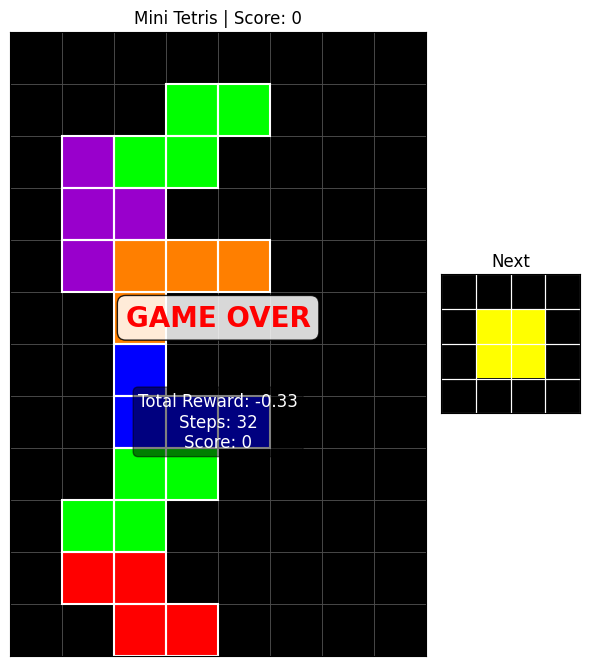


GAME OVER
Total Reward: -0.33
Steps: 32
Score: 0


In [3]:
import random

env = TetrisEnvNoPolicy()
state = env.reset()

total_reward = 0.0
print("=== RANDOM AGENT ===")

for step in range(100):

    action = random.choice([0, 1, 2, 3, 4])

    state, rw, done = env.step(action)
    total_reward += rw
    env.render(pause=0.15)

    print(f"Step {step:03d} | Action {action} | "
          f"Reward {rw:+.3f} | Total {total_reward:+.3f} | Done {done}")

    if done:
        info = (
            f"Total Reward: {total_reward:.2f}\n"
            f"Steps: {step}\n"
            f"Score: {env.score}"
        )

        env.render(pause=2.0, info_text=info)

        print("\nGAME OVER")
        print(info)
        break
